In [ ]:
!time pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 23.1 MB/s eta 0:00:00

real	0m17.455s
user	0m8.333s
sys	0m0.896s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sn
# import scipy as sp

import random
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style

#Dual active models

In [ ]:
import pandas as pd
sxl= pd.read_csv("M_sexual_LibrariesC_hits_nd_2ndclst_nhits.csv")
sxl['S_Hit'] = sxl['S_Hit'].replace(np.nan, "No")
sxl = sxl.iloc[: , 1:]
print(sxl['S_Hit'].value_counts())
sxl

## MACCSKeysFingerprint

In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 38.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [ ]:
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()

0    8975
1     916
Name: Target, dtype: int64

In [ ]:
dchm= sxl["Smiles"]
mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(mols)
df=[]
df = pd.DataFrame(maccs)
#df["Target"]= sxl["Target"]
df

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, sxl["Target"],test_size=0.2, random_state=42)

# Hyperparameter Tuning

---

Random Forest Hyperparameters we’ll be Looking at:

*   Number of trees (n_estimators)
*   Number of Samples (subsample)
*   Number of Features (max_features)
*   Learning Rate
*   Tree Depth (max_depth)
---
https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

>10 0.943 (0.003)
>50 0.960 (0.005)
>100 0.965 (0.005)
>500 0.977 (0.004)
>1000 0.979 (0.004)
>5000 0.978 (0.005)


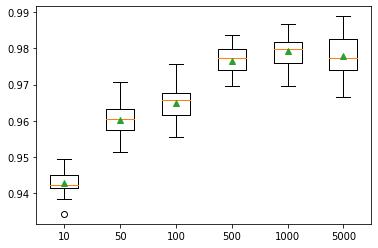

In [ ]:

# explore gradient boosting number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000, 5000]
	for n in n_trees:
		models[str(n)] = GradientBoostingClassifier(n_estimators=n)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>0.1 0.940 (0.025)
>1.1 nan (nan)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 317, in _check_params
    raise ValueError("subsample must be in (0,1] but was %r" % self.subsample)
ValueError: subsample mu

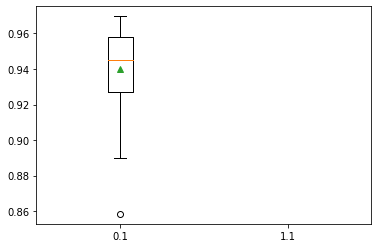

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore sample ratio from 10% to 100% in 10% increments
	for i in (0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = GradientBoostingClassifier(subsample=i, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 20
	for i in range(1,21):
		models[str(i)] = GradientBoostingClassifier(max_features=i, subsample=0.1, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>1 0.963 (0.019)
>2 0.935 (0.094)
>3 0.953 (0.047)
>4 0.916 (0.098)
>5 0.898 (0.109)


KeyboardInterrupt: ignored

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# define learning rates to explore
	for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
		key = '%.4f' % i
		models[key] = GradientBoostingClassifier(learning_rate=i, max_features=i, subsample=0.1, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# get a list of models to evaluate
def get_models():
	models = dict()
	# define max tree depths to explore between 1 and 10
	for i in range(1,11):
		models[str(i)] = GradientBoostingClassifier(max_depth=i, learning_rate=i, max_features=i, subsample=0.1, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X = df
y = sxl["Target"]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# example of grid searching key hyperparameters for gradient boosting on a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
# define dataset
X = Xt_train
y = Yt_train
# define the model with default hyperparameters
model = GradientBoostingClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [ 500]
grid['learning_rate'] = [ 0.001, 0.01, 0.1]
grid['subsample'] = [0.1]
grid['max_depth'] = [3, 7, 9]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.969877 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.908367 (0.000610) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.908367 (0.000610) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.908367 (0.000610) with: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.960439 (0.005620) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.969413 (0.005733) with: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.969877 (0.005482) with: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.959385 (0.014274) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.693676 (0.179044) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.674639 (0.170951) with: {'learning_rate': 0.1, 'max_depth

#Training

In [ ]:
# load library
from sklearn.ensemble import GradientBoostingClassifier
# Best: 0.969877 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
xgbc = GradientBoostingClassifier( learning_rate=0.01, subsample=0.1, n_estimators=500, max_depth= 9)

# fit the predictor and target
xgbc.fit(Xt_train, Yt_train)


In [ ]:
# Save Model Using joblib
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib

%cd /content/
# save the model to disk
filename = 'sexualsGBM_HPTFInal_UMACCS_model.pkl'
joblib.dump(xgbc, filename)

#Creating unbalanced test set

In [ ]:
############################################Sexual data
import pandas as pd
sxl= pd.read_csv("M_sexual_LibrariesC_hits_nd_2ndclst_nhits.csv")
sxl['S_Hit'] = sxl['S_Hit'].replace(np.nan, "No")
sxl = sxl.iloc[: , 1:]
print(sxl['S_Hit'].value_counts())
sxl

In [ ]:
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()

0    8975
1     916
Name: Target, dtype: int64

,Smiles,S_Hit,Target,ROMol
0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12,Yes,1,
1,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1,Yes,1,
2,COc1c(C)cnc(CN(C)C2CCCCC2)c1C,Yes,1,
3,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1,Yes,1,
4,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C,Yes,1,
...,...,...,...,...
9886,Cc1nc(C)n(C2CCCN(C(=O)c3ncoc3C(C)C)C2)n1,No,0,
9887,COCCN1CCN(Cc2c(C)noc2C)Cc2ccc(C)nc21,No,0,
9888,CCc1ncnc2c1CCN(Cc1ccc3c(c1)OCO3)CC2,No,0,
9889,CCC1CN(CC(=O)NCCN2CCCCCC2)c2ccccc2S1,No,0,

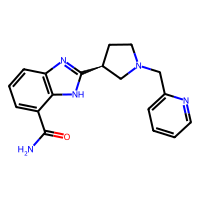
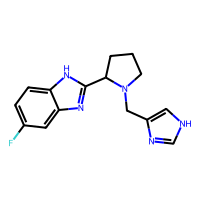
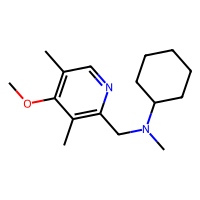
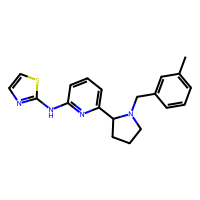
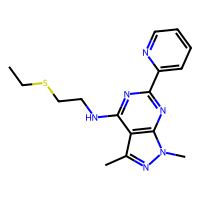
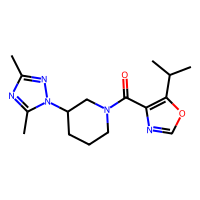
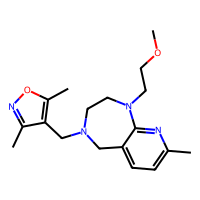
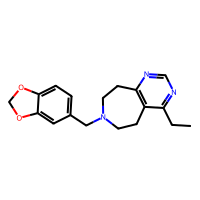
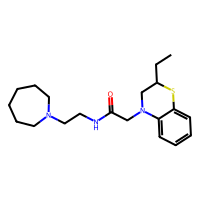
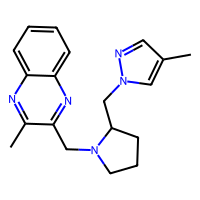

In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit

# using pandastools to create molecule from smiles within the dataframe
PandasTools.AddMoleculeColumnToFrame(sxl,smilesCol="Smiles")
sxl.head()

sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()
sxl

## MACCSKeysFingerprint

In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dpchm= sxl
#dchm
dpchm["Target"] = np.where(dpchm["S_Hit"]== "Yes", 1,0)
dpchm["Target"].value_counts()

dchm= dpchm["ROMol"]
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
#mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(dchm)
df=[]
df = pd.DataFrame(maccs)
#df["Target"]= sxl["Target"]
df["Smiles"]= sxl["Smiles"]
df

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,Smiles
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,1,0,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,COc1c(C)cnc(CN(C)C2CCCCC2)c1C
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,1,0,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,1,0,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,Cc1nc(C)n(C2CCCN(C(=O)c3ncoc3C(C)C)C2)n1
9887,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,COCCN1CCN(Cc2c(C)noc2C)Cc2ccc(C)nc21
9888,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,CCc1ncnc2c1CCN(Cc1ccc3c(c1)OCO3)CC2
9889,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,CCC1CN(CC(=O)NCCN2CCCCCC2)c2ccccc2S1


In [ ]:
from sklearn.model_selection import train_test_split
Xt_train1, Xt_test1, Yt_train1, Yt_test1 = train_test_split(df, sxl["Target"],test_size=0.2, random_state=42)

# Unbalanced test set

In [ ]:
##Select those not in train set


In [ ]:
sxl= pd.read_csv("Merged_sexual_libraries_hits and nonhits_nd.csv")
print(sxl["S_Hit"].count())
nht= sxl[sxl["S_Hit"]== "No"]
nhts= nht[["Smiles", "S_Hit"]]
nhts = nhts.reset_index(drop=True)
nhts

/content
69011


,Smiles,S_Hit
0,Cc1cnn(CC2CCCCN2Cc2nnsc2Cl)c1,No
1,CC(=O)N1CC[C@H]2CC(=O)N(C3CCCCC3)CC[C@H]2C1,No
2,Cc1cc(=O)[nH]c(=O)n1-c1cccc(Cl)c1Cl,No
3,COC(=O)c1ccccc1S(=O)(=O)NC(=O)c1cccc2c1OCCO2,No
4,Cc1noc(C2CCCN(C(=O)c3ccc(N(C)C)nc3)C2)n1,No
...,...,...
68796,CC(=O)Nc1nnc(SCc2c(C)cc(cc2C)C(C)(C)C)s1,No
68797,Cc1ccc(cc1)S(=O)(=O)c2c(COC(=O)c3cccc(C)c3)c(n...,No
68798,COc1ccc(OC)c(c1)C2C3=C(CC(C)(C)CC3=O)N(C4=C2C(...,No
68799,Cc1cc(C=C2SC(=Nc3ccccc3)N(C4CCCC4)C2=O)c(C)n1c...,No


In [ ]:
############################################Sexual data
#Optional: move to the desired location:
import pandas as pd
sxl1= pd.read_csv("M_sexual_LibrariesC_hits_nd_2ndclst_nhits.csv")
sxl1['S_Hit'] = sxl1['S_Hit'].replace(np.nan, "No")
sxl1 = sxl1.iloc[: , 1:]
print(sxl1['S_Hit'].value_counts())
sxl1



/content/drive/MyDrive/PhD/PTS_datasets
No     8975
Yes     916
Name: S_Hit, dtype: int64


,Smiles,S_Hit
0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12,Yes
1,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1,Yes
2,COc1c(C)cnc(CN(C)C2CCCCC2)c1C,Yes
3,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1,Yes
4,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C,Yes
...,...,...
9886,Cc1nc(C)n(C2CCCN(C(=O)c3ncoc3C(C)C)C2)n1,No
9887,COCCN1CCN(Cc2c(C)noc2C)Cc2ccc(C)nc21,No
9888,CCc1ncnc2c1CCN(Cc1ccc3c(c1)OCO3)CC2,No
9889,CCC1CN(CC(=O)NCCN2CCCCCC2)c2ccccc2S1,No


In [ ]:
ht= sxl1[sxl1["S_Hit"]== "Yes"]
ht = ht.reset_index(drop=True)
ht

,Smiles,S_Hit
0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12,Yes
1,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1,Yes
2,COc1c(C)cnc(CN(C)C2CCCCC2)c1C,Yes
3,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1,Yes
4,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C,Yes
...,...,...
911,COc1cc2nc(N3CCC(CCCC4CCNCC4)CC3)nc(NCc3ccccn3)...,Yes
912,Cc1ccc(Cl)c2sc(N3CCN(C(=O)c4ccc([N+](=O)[O-])o...,Yes
913,CCCCCCCN1CC[C@@H](CCCc2ccnc3ccc(OC)cc23)[C@@H]...,Yes
914,CN(C)CCNCc1cccc(-c2ccc3c(Nc4ccc(Oc5ccccn5)cc4)...,Yes


In [ ]:
sxl= nhts.append(ht)
sxl = sxl.reset_index(drop=True)
sxl

<ipython-input-14-9d4f6c643dad>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sxl= nhts.append(ht)


,Smiles,S_Hit
0,Cc1cnn(CC2CCCCN2Cc2nnsc2Cl)c1,No
1,CC(=O)N1CC[C@H]2CC(=O)N(C3CCCCC3)CC[C@H]2C1,No
2,Cc1cc(=O)[nH]c(=O)n1-c1cccc(Cl)c1Cl,No
3,COC(=O)c1ccccc1S(=O)(=O)NC(=O)c1cccc2c1OCCO2,No
4,Cc1noc(C2CCCN(C(=O)c3ccc(N(C)C)nc3)C2)n1,No
...,...,...
69712,COc1cc2nc(N3CCC(CCCC4CCNCC4)CC3)nc(NCc3ccccn3)...,Yes
69713,Cc1ccc(Cl)c2sc(N3CCN(C(=O)c4ccc([N+](=O)[O-])o...,Yes
69714,CCCCCCCN1CC[C@@H](CCCc2ccnc3ccc(OC)cc23)[C@@H]...,Yes
69715,CN(C)CCNCc1cccc(-c2ccc3c(Nc4ccc(Oc5ccccn5)cc4)...,Yes


In [ ]:
df_smiles = sxl

## MACCSKeysFingerprint

In [ ]:
# rdkit seems to get stuck at certain parts when converting smiles into mols and
# and gives C++ coverter error. However when I split the dataset at these parts
# this seems to prevent the error.
compounds = []

df1 = df_smiles. iloc [:176]
for _, compound_key, smiles in df1[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df2 = df_smiles. iloc [177:637]
for _, compound_key, smiles in df2[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df3 = df_smiles. iloc [638:880]
for _, compound_key, smiles in df3[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df4 = df_smiles. iloc [881:2160]
for _, compound_key, smiles in df4[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df5 = df_smiles. iloc [2161:2662]
for _, compound_key, smiles in df5[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df6 = df_smiles. iloc [2663:4273]
for _, compound_key, smiles in df6[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df7 = df_smiles. iloc [4274:8027]
for _, compound_key, smiles in df7[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df8 = df_smiles. iloc [8028:8749]
for _, compound_key, smiles in df8[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df9 = df_smiles. iloc [8750:9132]
for _, compound_key, smiles in df9[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df10 = df_smiles. iloc [9133:9993]
for _, compound_key, smiles in df10[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df11 = df_smiles. iloc [9994:15541]
for _, compound_key, smiles in df11[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df12 = df_smiles. iloc [15544:17608]
for _, compound_key, smiles in df12[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df13 = df_smiles. iloc [17609:18039]
for _, compound_key, smiles in df13[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df14 = df_smiles. iloc [18040:19840]
for _, compound_key, smiles in df14[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df15 = df_smiles. iloc [19841:21008]
for _, compound_key, smiles in df15[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df16 = df_smiles. iloc [21009:23464]
for _, compound_key, smiles in df16[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df17 = df_smiles. iloc [23465:24399]
for _, compound_key, smiles in df17[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df18 = df_smiles. iloc [24400:24499]
for _, compound_key, smiles in df18[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df19 = df_smiles. iloc [24500:27475]
for _, compound_key, smiles in df19[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df20 = df_smiles. iloc [27476:29517]
for _, compound_key, smiles in df20[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df21 = df_smiles. iloc [29518:32330]
for _, compound_key, smiles in df21[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df22 = df_smiles. iloc [32331:34028]
for _, compound_key, smiles in df22[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))
df23 = df_smiles. iloc [34029:36109]
for _, compound_key, smiles in df23[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df24 = df_smiles. iloc [36110:39916]
for _, compound_key, smiles in df24[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df25 = df_smiles. iloc [39917:40726]
for _, compound_key, smiles in df25[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


df26 = df_smiles. iloc [40727:42620]
for _, compound_key, smiles in df26[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df27 = df_smiles. iloc [42624:42974]
for _, compound_key, smiles in df27[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df28 = df_smiles. iloc [42975:45122]
for _, compound_key, smiles in df28[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


df29 = df_smiles. iloc [45123:45283]
for _, compound_key, smiles in df29[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df30 = df_smiles. iloc [45284:46911]
for _, compound_key, smiles in df30[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df31 = df_smiles. iloc [46912:49127]
for _, compound_key, smiles in df31[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df32 = df_smiles. iloc [49128:50625]
for _, compound_key, smiles in df32[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df33 = df_smiles. iloc [50626:51114]
for _, compound_key, smiles in df33[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df34 = df_smiles. iloc [51115:53592]
for _, compound_key, smiles in df34[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df35 = df_smiles. iloc [53593:54321]
for _, compound_key, smiles in df35[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df36 = df_smiles. iloc [54322:54557]
for _, compound_key, smiles in df36[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df37 = df_smiles. iloc [54558:55534]
for _, compound_key, smiles in df37[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df38 = df_smiles. iloc [55536:55615]
for _, compound_key, smiles in df38[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df39 = df_smiles. iloc [55617:59191]
for _, compound_key, smiles in df39[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df40 = df_smiles. iloc [59192:61821]
for _, compound_key, smiles in df40[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df41 = df_smiles. iloc [61822:62027]
for _, compound_key, smiles in df41[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df42 = df_smiles. iloc [62028:63298]
for _, compound_key, smiles in df42[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df43 = df_smiles. iloc [63299:63676]
for _, compound_key, smiles in df43[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df44 = df_smiles. iloc [63677:68352]
for _, compound_key, smiles in df44[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df45 = df_smiles. iloc [68353:]
for _, compound_key, smiles in df45[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'S_Hit', "Smiles"])
sxl=dff
sxl

,mol,S_Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7fdf31b3f5a0>,No,Cc1cnn(CC2CCCCN2Cc2nnsc2Cl)c1
1,<rdkit.Chem.rdchem.Mol object at 0x7fdf31b3f060>,No,CC(=O)N1CC[C@H]2CC(=O)N(C3CCCCC3)CC[C@H]2C1
2,<rdkit.Chem.rdchem.Mol object at 0x7fdf31b3ee30>,No,Cc1cc(=O)[nH]c(=O)n1-c1cccc(Cl)c1Cl
3,<rdkit.Chem.rdchem.Mol object at 0x7fdf31b3ed50>,No,COC(=O)c1ccccc1S(=O)(=O)NC(=O)c1cccc2c1OCCO2
4,<rdkit.Chem.rdchem.Mol object at 0x7fdf31b3ece0>,No,Cc1noc(C2CCCN(C(=O)c3ccc(N(C)C)nc3)C2)n1
...,...,...,...
69661,<rdkit.Chem.rdchem.Mol object at 0x7fdf327d1380>,Yes,COc1cc2nc(N3CCC(CCCC4CCNCC4)CC3)nc(NCc3ccccn3)...
69662,<rdkit.Chem.rdchem.Mol object at 0x7fdf327d13f0>,Yes,Cc1ccc(Cl)c2sc(N3CCN(C(=O)c4ccc([N+](=O)[O-])o...
69663,<rdkit.Chem.rdchem.Mol object at 0x7fdf327d1460>,Yes,CCCCCCCN1CC[C@@H](CCCc2ccnc3ccc(OC)cc23)[C@@H]...
69664,<rdkit.Chem.rdchem.Mol object at 0x7fdf327d14d0>,Yes,CN(C)CCNCc1cccc(-c2ccc3c(Nc4ccc(Oc5ccccn5)cc4)...


In [ ]:
df3 = sxl.loc[~sxl['Smiles'].isin(Xt_train1['Smiles'])].copy()

In [ ]:

# shuffle the DataFrame rows
df3 = df3.sample(frac = 1)
sxl=df3
sxl

,mol,S_Hit,Smiles
29524,<rdkit.Chem.rdchem.Mol object at 0x7fdf32cf4900>,No,Cc1cccc(-n2nnnc2C(C)(C)Nc2ccccc2C)c1
51616,<rdkit.Chem.rdchem.Mol object at 0x7fdf32abec70>,No,CC(C)c1cc(C(=O)N2C[C@@H]3CC[C@H]2CN(Cc2ccccn2)...
5589,<rdkit.Chem.rdchem.Mol object at 0x7fdf3310f990>,No,CCOC(=O)C1CCCN(c2nccc(-n3nc(C)cc3C)n2)C1
59774,<rdkit.Chem.rdchem.Mol object at 0x7fdf32824350>,No,Cc1noc(C2CCCCN2C(=O)NCc2ccco2)n1
6660,<rdkit.Chem.rdchem.Mol object at 0x7fdf34d54f20>,No,CC(C)c1n[nH]c(C(=O)Nc2ccncc2)c1Br
...,...,...,...
35026,<rdkit.Chem.rdchem.Mol object at 0x7fdf32de4740>,No,CCCN(C)CCC(=O)N1CCCC1Cn1cccn1
4049,<rdkit.Chem.rdchem.Mol object at 0x7fdf332cd070>,No,CCc1nnc(CN2CCC(c3nc4cc(Cl)ccc4o3)CC2)o1
34604,<rdkit.Chem.rdchem.Mol object at 0x7fdf32dd4dd0>,No,CC(C)N1CCC(CC(=O)NCCc2cc(O)ncn2)CC1
32528,<rdkit.Chem.rdchem.Mol object at 0x7fdf32d77760>,No,Cc1ccc(N(C)S(=O)(=O)c2cc(C(=O)O)cs2)c(C)c1


In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

dpchm= sxl
dpchm
dpchm["Target"] = np.where(dpchm["S_Hit"]== "Yes", 1,0)
dpchm["Target"].value_counts()

dchm= dpchm["mol"]
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
#mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(dchm)
df=[]
df = pd.DataFrame(maccs)

df

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62370,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,1,1,0
62371,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
62372,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
62373,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [ ]:
Xt_test = df
Yt_test= sxl["Target"]

#GBM

In [ ]:

gbm_model = joblib.load('sexualsGBM_HPTFInal_UMACCS_model.pkl')

In [ ]:
xgbc_predict = gbm_model.predict(Xt_test)
p= xgbc_predict
p= pd.DataFrame(p)
print(p.value_counts())


0    61896
1      479
dtype: int64


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,xgbc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,xgbc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,xgbc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,xgbc_predict)
print('F1 score: %f' % f1)
cm= confusion_matrix(Yt_test,xgbc_predict)
cm

Accuracy: 0.992818
Recall 0.632479
precision 0.154489
F1 score: 0.248322


array([[61853,   405],
       [   43,    74]])

In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, xgbc_predict))
print('Accuracy score:',accuracy_score(Yt_test, xgbc_predict))
print('F1 score:',f1_score(Yt_test,xgbc_predict))

ROCAUC score: 0.8129867221951773
Accuracy score: 0.9928176352705411
F1 score: 0.24832214765100669


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, xgbc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, xgbc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, xgbc_predict)
print(matrix)

Cohens kappa: 0.246049
ROC AUC: 0.812987
[[61853   405]
 [   43    74]]


#Asexual models

In [ ]:
import pandas as pd
axl= pd.read_csv("M_asexuals_lib_hits_nd_clst_nhts.csv")
axl['Hit'] = axl['Hit'].replace(np.nan, "No")
axl = axl.iloc[: , 1:]
print(axl['Hit'].value_counts())
axl

In [ ]:
compounds =[]
df1= axl[:20000]

for _, smiles, hit in df1[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df2= axl[20001:23766]

for _, smiles, hit in df2[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df3= axl[23767:25396]

for _, smiles, hit in df3[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))


df4= axl[25397:25662]

for _, smiles, hit in df4[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df5= axl[25663:26912]

for _, smiles, hit in df5[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df6= axl[26913:28399]

for _, smiles, hit in df6[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df7= axl[28400:]

for _, smiles, hit in df7[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

len(compounds)

59530

In [ ]:
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()

1    30393
0    29143
Name: Target, dtype: int64

In [ ]:
compounds
dpchm= pd.DataFrame (compounds, columns = ['mol', 'hit'])
dpchm["Target"] = np.where(dpchm["hit"]== "Yes", 1,0)
dpchm["Target"].value_counts()

dchm= dpchm["mol"]
dchm

0        <rdkit.Chem.rdchem.Mol object at 0x7f695b8060b0>
1        <rdkit.Chem.rdchem.Mol object at 0x7f695b806120>
2        <rdkit.Chem.rdchem.Mol object at 0x7f695b806190>
3        <rdkit.Chem.rdchem.Mol object at 0x7f695b806200>
4        <rdkit.Chem.rdchem.Mol object at 0x7f695b806270>
                               ...                       
59525    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81dd0>
59526    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81e40>
59527    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81eb0>
59528    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81f20>
59529    <rdkit.Chem.rdchem.Mol object at 0x7f695aa81f90>
Name: mol, Length: 59530, dtype: object

## MACCSKeysFingerprint

In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
#mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(dchm)
df=[]
df = pd.DataFrame(maccs)
dpchm['hit']= np.where(dpchm['hit']== "Yes", 1,0)

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, dpchm['hit'],test_size=0.2, random_state=42)

# Hyperparameter Tuning

---

Random Forest Hyperparameters we’ll be Looking at:

*   Number of trees (n_estimators)
*   Number of Samples (subsample)
*   Number of Features (max_features)
*   Learning Rate
*   Tree Depth (max_depth)
---
https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

In [ ]:

# evaluate gradient boosting algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:

# explore gradient boosting number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = GradientBoostingClassifier(n_estimators=n)
	return models


 # define dataset
X = Xt_train
y = Yt_train

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores


# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>10 0.840 (0.005)
>50 0.891 (0.005)
>100 0.908 (0.004)
>500 0.933 (0.004)


KeyboardInterrupt: ignored

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore sample ratio from 10% to 100% in 10% increments
	for i in (0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = GradientBoostingClassifier(subsample=i, n_estimators=500)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

 # define dataset
X = Xt_train
y = Yt_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

KeyboardInterrupt: ignored

In [ ]:

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 20
	for i in range(1,21):
		models[str(i)] = GradientBoostingClassifier(max_features=i, subsample=0.1, n_estimators=1000)
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

 # define dataset
X = Xt_train
y = Yt_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>1 0.963 (0.019)
>2 0.935 (0.094)
>3 0.953 (0.047)
>4 0.916 (0.098)
>5 0.898 (0.109)


KeyboardInterrupt: ignored

In [ ]:
# example of grid searching key hyperparameters for gradient boosting on a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
# define dataset
X = Xt_train
y = Yt_train
# define the model with default hyperparameters
model = GradientBoostingClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [ 500]
grid['learning_rate'] = [ 0.01, 0.1]
grid['subsample'] = [0.1]
grid['max_depth'] = [3, 7, 9]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.935999 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.892449 (0.002100) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.925899 (0.001743) with: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.935999 (0.002730) with: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
0.922665 (0.001785) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.1}
0.859357 (0.015328) with: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.1}
0.699836 (0.037649) with: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}


# Training

In [ ]:
# load library
from sklearn.ensemble import GradientBoostingClassifier
# Best: 0.969877 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.1}
xgbc = GradientBoostingClassifier( learning_rate=0.01, subsample=0.1, n_estimators=500, max_depth= 9)

# fit the predictor and target
xgbc.fit(Xt_train, Yt_train)

In [ ]:
# Save Model Using joblib
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib

%cd /content/
# save the model to disk
filename = 'asexualsGBM_HPTFInal_UMACCS_model.pkl'
joblib.dump(xgbc, filename)

#Creating unbalanced test set

In [ ]:
import pandas as pd
axl= pd.read_csv("M_asexuals_lib_hits_nd_clst_nhts.csv")
axl['Hit'] = axl['Hit'].replace(np.nan, "No")
axl = axl.iloc[: , 1:]
print(axl['Hit'].value_counts())
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()

1    30393
0    29143
Name: Target, dtype: int64

In [ ]:
# rdkit seems to get stuck at certain parts when converting smiles into mols and
# and gives C++ coverter error. However when I split the dataset at these parts
# this seems to prevent the error.
compounds =[]
df1= axl[:20000]

for _, smiles, hit in df1[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))

df2= axl[20001:23766]

for _, smiles, hit in df2[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))
df3= axl[23767:25396]

for _, smiles, hit in df3[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))


df4= axl[25397:25662]

for _, smiles, hit in df4[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))

df5= axl[25663:26912]

for _, smiles, hit in df5[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))

df6= axl[26913:28399]

for _, smiles, hit in df6[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))
df7= axl[28400:]

for _, smiles, hit in df7[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))

len(compounds)

59530

In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit', "Smiles"])
axl=dff

## MACCSKeysFingerprint

In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dpchm= axl
dpchm["Target"] = np.where(dpchm["Hit"]== "Yes", 1,0)
dpchm["Target"].value_counts()

dchm= dpchm["mol"]
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
#mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(dchm)
df=[]
df = pd.DataFrame(maccs)
#df["Target"]= sxl["Target"]
df["Smiles"]= axl["Smiles"]
df

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,Smiles
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,Cc1cccnc1CN1CC[C@H](Oc2cccc(F)c2)[C@@](C)(O)C1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,CC(C)(C)C(=O)N1C[C@H](c2ccsc2)[C@H]2CN(C3CCCCC...
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,CC(C)N(CCNC(=O)c1[nH]nc2ccc(I)cc12)C(C)C
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,1,0,CC(Nc1nc(-c2ccncc2)nc2c1CCNC2)c1ccccc1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,CC(C)C[C@H](N)COc1cccc(F)c1Oc1cccc(Cl)c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59525,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,O=C1CC[C@H]2[C@H](CCN2C(=O)C2CCOC2)N1Cc1ccncc1
59526,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,1,0,Cc1cc(Nc2ccc(F)cn2)cc(C2CCN(Cc3ncc[nH]3)C2)n1
59527,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,O=C(CCNc1ccccc1)NC1CCN(C(=O)C2CCCCC2)CC1
59528,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,CN(C)c1nc2c(c(N3CCC(O)CC3)n1)CN(CC1CCNC1)CC2


In [ ]:
from sklearn.model_selection import train_test_split
Xt_train1, Xt_test1, Yt_train1, Yt_test1 = train_test_split(df, axl["Target"],test_size=0.2, random_state=42)

# Unbalanced test set

In [ ]:
##Select those not in train set
sxl= pd.read_csv("Merged_asexual_libraries_hits and nonhits_nd.csv")
as_nhts= sxl[sxl["Hit"]== "No"]
print(len(as_nhts))

df_smiles = as_nhts[['Smiles',"Compound Key", "Hit"]]
print(len(df_smiles))
df_smiles

,Unnamed: 0,Smiles,CHEMBLID,Hit,Compound Key
0,0,O=C(OCc1ccccc1)N1CC[C@H]2CC(CO)O[C@@H]2C1,CHEMBL3470688,No,DDD01082494
1,1,Cc1cc(C(=O)N(C)C)nc(C2(C)CCCN2c2ccccc2)n1,CHEMBL3447812,No,DDD01058126
2,2,CN(C)c1nc2c(c(N3CCC(O)CC3)n1)CN(CC1CCNC1)CC2,CHEMBL3486462,No,DDD01257825
3,3,O=C1CCC(C(=O)Nc2cnn(-c3ccccc3Br)c2)N1,CHEMBL3467813,No,DDD01078886
4,4,O=C(CCNc1ccccc1)NC1CCN(C(=O)C2CCCCC2)CC1,CHEMBL3452692,No,DDD01063562
...,...,...,...,...,...
122566,122566,CC(/C=C/C(=O)NO)=C\[C@@H](C)C(=O)c1ccc(N(C)C)cc1,CHEMBL99,Yes,GNF-Pf-1011
122567,122567,O=[N+]([O-])c1cc([N+](=O)[O-])c2cccnc2c1Nc1ccc...,CHEMBL603032,No,GNF-Pf-1014
122568,122568,COc1ccc2c(c1)N(C(=O)CSc1nc3ccccc3o1)C(C)(C)c1s...,CHEMBL585033,Yes,GNF-Pf-4623
122569,122569,CCN1/C(=C/c2cccc[n+]2C)Sc2ccccc21,CHEMBL583805,Yes,GNF-Pf-1023


In [ ]:
# rdkit seems to get stuck at certain parts when converting smiles into mols and
# and gives C++ coverter error. However when I split the dataset at these parts
# this seems to prevent the error.
compounds = []
df1 = df_smiles. iloc [:1300]
df2 = df_smiles. iloc [1301:2600]
df3 = df_smiles. iloc [2601:3900]
df4 = df_smiles. iloc [3901:4300] #note error observed between compounds 4301-4310
df5 = df_smiles. iloc [4310:4600]

for _, compound_key, smiles in df1[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

for _, compound_key, smiles  in df2[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

for _, compound_key, smiles in df3[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

for _, compound_key, smiles in df4[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

for _, compound_key, smiles in df5[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key , smiles))

df6 = df_smiles. iloc [4650:5600]
for _, compound_key, smiles in df6[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key , smiles))

df7 = df_smiles. iloc [5700:6150]
for _, compound_key, smiles in df7[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key , smiles))

df8 = df_smiles. iloc [6180:7970]
for _, compound_key, smiles  in df8[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df9 = df_smiles. iloc [8000:10730]
for _, compound_key, smiles  in df9[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df10 = df_smiles. iloc [10740:11410]
for _, compound_key, smiles in df10[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df11 = df_smiles. iloc [11420:14010]
for _, compound_key, smiles in df11[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df12 = df_smiles. iloc [14020:14580]
for _, compound_key, smiles in df12[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df13 = df_smiles. iloc [14590:15794]
for _, compound_key, smiles  in df13[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df14 = df_smiles. iloc [15795:18061]
for _, compound_key, smiles  in df14[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df15 = df_smiles. iloc [18062:20531]
for _, compound_key, smiles  in df15[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df16 = df_smiles. iloc [20532:20964]
for _, compound_key, smiles in df16[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df17 = df_smiles. iloc [20966:22471]
for _, compound_key, smiles in df17[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df18 = df_smiles. iloc [22473:25150]
for _, compound_key, smiles in df18[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df19 = df_smiles. iloc [25153:25549]
for _, compound_key, smiles  in df19[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df20= df_smiles. iloc [25551:28743]
for _, compound_key, smiles in df20[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df21= df_smiles. iloc [28755:30045]
for _, compound_key, smiles  in df21[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df22= df_smiles. iloc [30047:30857]
for _, compound_key, smiles  in df22[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df23= df_smiles. iloc [30859:31442]
for _, compound_key, smiles  in df23[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df24= df_smiles. iloc [31444:31831]
for _, compound_key, smiles in df24[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df25= df_smiles. iloc [31833:33515]
for _, compound_key, smiles  in df25[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df26= df_smiles. iloc [33517:33577]
for _, compound_key, smiles  in df26[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df27= df_smiles. iloc [33579:35623]
for _, compound_key, smiles in df27[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df28= df_smiles. iloc [35625:36239]
for _, compound_key, smiles  in df28[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df29= df_smiles. iloc [36240:38411]
for _, compound_key, smiles in df29[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df30= df_smiles. iloc [38413:38536]
for _, compound_key, smiles in df30[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df31= df_smiles. iloc [38538:39460]
for _, compound_key, smiles in df31[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df32= df_smiles. iloc [39462:39880]
for _, compound_key, smiles in df32[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df33= df_smiles. iloc [39882:44468]
for _, compound_key, smiles  in df33[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df34= df_smiles. iloc [44479:45910]
for _, compound_key, smiles  in df34[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df35= df_smiles. iloc [45912:50308]
for _, compound_key, smiles in df35[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df36= df_smiles. iloc [50310:50644]
for _, compound_key, smiles in df36[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df37= df_smiles. iloc [50646:50847]
for _, compound_key, smiles in df37[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df38= df_smiles. iloc [50849:51016]
for _, compound_key, smiles  in df38[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df39= df_smiles. iloc [51018:52255]
for _, compound_key, smiles  in df39[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df40= df_smiles. iloc [52257:52515]
for _, compound_key, smiles  in df40[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df41= df_smiles. iloc [52517:54570]
for _, compound_key, smiles in df41[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df42= df_smiles. iloc [54572:56375]
for _, compound_key, smiles in df42[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df43= df_smiles. iloc [56377:57950]
for _, compound_key, smiles  in df43[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df44= df_smiles. iloc [57952:60363]
for _, compound_key, smiles  in df44[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df45= df_smiles. iloc [60365:61892]
for _, compound_key, smiles in df45[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df46= df_smiles. iloc [61894:86486]
for _, compound_key, smiles in df46[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df47= df_smiles. iloc [86488:87067]
for _, compound_key, smiles in df47[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df48= df_smiles. iloc [87069:89383]
for _, compound_key, smiles  in df48[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df49= df_smiles. iloc [89385:90154]
for _, compound_key, smiles in df49[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df50= df_smiles. iloc [90156:90354]
for _, compound_key, smiles in df50[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df51= df_smiles. iloc [90356:90609]
for _, compound_key, smiles  in df51[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df52= df_smiles. iloc [90611:90746]
for _, compound_key, smiles in df52[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df53= df_smiles. iloc [90748:92006]
for _, compound_key, smiles  in df53[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df54= df_smiles. iloc [92008:]
for _, compound_key, smiles  in df54[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

len(compounds)

91817

In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit', "Smiles"])
sxl=dff
sxl

,mol,Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7fdf33cef140>,No,O=C(OCc1ccccc1)N1CC[C@H]2CC(CO)O[C@@H]2C1
1,<rdkit.Chem.rdchem.Mol object at 0x7fdf33ceeff0>,No,Cc1cc(C(=O)N(C)C)nc(C2(C)CCCN2c2ccccc2)n1
2,<rdkit.Chem.rdchem.Mol object at 0x7fdf33cefd80>,No,CN(C)c1nc2c(c(N3CCC(O)CC3)n1)CN(CC1CCNC1)CC2
3,<rdkit.Chem.rdchem.Mol object at 0x7fdf33ceef80>,No,O=C1CCC(C(=O)Nc2cnn(-c3ccccc3Br)c2)N1
4,<rdkit.Chem.rdchem.Mol object at 0x7fdf33cef8b0>,No,O=C(CCNc1ccccc1)NC1CCN(C(=O)C2CCCCC2)CC1
...,...,...,...
91812,<rdkit.Chem.rdchem.Mol object at 0x7fdf26bc9bd0>,No,O=C(CNCCc1ccccc1)NC(c1ccccc1)c1ccccc1.O=CO.O=CO
91813,<rdkit.Chem.rdchem.Mol object at 0x7fdf26bc9c40>,No,Cc1ccc(COc2ccc3c(C#N)c4ccccn4c3c2)cc1
91814,<rdkit.Chem.rdchem.Mol object at 0x7fdf26bc9cb0>,No,O=C(CN1CCN(S(=O)(=O)c2cccc([N+](=O)[O-])c2)CC1...
91815,<rdkit.Chem.rdchem.Mol object at 0x7fdf26bc9d20>,No,CC(C)N(CC(=O)Nc1cc(C(C)(C)C)nn1-c1ccc(Cl)c(Cl)...


In [ ]:
import pandas as pd
axl= pd.read_csv("M_asexuals_lib_hits_nd_clst_nhts.csv")
axl['Hit'] = axl['Hit'].replace(np.nan, "No")
axl = axl.iloc[: , 1:]
print(axl['Hit'].value_counts())
axl

/content/drive/MyDrive/PhD/PTS_datasets
Yes    30393
No     29143
Name: Hit, dtype: int64


,Smiles,Hit
0,Cc1cccnc1CN1CC[C@H](Oc2cccc(F)c2)[C@@](C)(O)C1,Yes
1,CC(C)(C)C(=O)N1C[C@H](c2ccsc2)[C@H]2CN(C3CCCCC...,Yes
2,CC(C)N(CCNC(=O)c1[nH]nc2ccc(I)cc12)C(C)C,Yes
3,CC(Nc1nc(-c2ccncc2)nc2c1CCNC2)c1ccccc1,Yes
4,CC(C)C[C@H](N)COc1cccc(F)c1Oc1cccc(Cl)c1,Yes
...,...,...
59531,O=C1CC[C@H]2[C@H](CCN2C(=O)C2CCOC2)N1Cc1ccncc1,No
59532,Cc1cc(Nc2ccc(F)cn2)cc(C2CCN(Cc3ncc[nH]3)C2)n1,No
59533,O=C(CCNc1ccccc1)NC1CCN(C(=O)C2CCCCC2)CC1,No
59534,CN(C)c1nc2c(c(N3CCC(O)CC3)n1)CN(CC1CCNC1)CC2,No


In [ ]:
compounds =[]
df1= axl[:20000]

for _, smiles, hit in df1[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df2= axl[20001:23766]

for _, smiles, hit in df2[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df3= axl[23767:25396]

for _, smiles, hit in df3[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))


df4= axl[25397:25662]

for _, smiles, hit in df4[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df5= axl[25663:26912]

for _, smiles, hit in df5[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df6= axl[26913:28399]

for _, smiles, hit in df6[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df7= axl[28400:]

for _, smiles, hit in df7[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

len(compounds)

59530

In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit', "Smiles"])
axl2=dff
as_ht= axl2[axl2["Hit"]== "Yes"]

In [ ]:
axl= sxl.append(as_ht)
axl = axl.reset_index(drop=True)
axl

<ipython-input-70-71be01537f27>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  axl= sxl.append(as_ht)


,mol,Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7fdf33cef140>,No,O=C(OCc1ccccc1)N1CC[C@H]2CC(CO)O[C@@H]2C1
1,<rdkit.Chem.rdchem.Mol object at 0x7fdf33ceeff0>,No,Cc1cc(C(=O)N(C)C)nc(C2(C)CCCN2c2ccccc2)n1
2,<rdkit.Chem.rdchem.Mol object at 0x7fdf33cefd80>,No,CN(C)c1nc2c(c(N3CCC(O)CC3)n1)CN(CC1CCNC1)CC2
3,<rdkit.Chem.rdchem.Mol object at 0x7fdf33ceef80>,No,O=C1CCC(C(=O)Nc2cnn(-c3ccccc3Br)c2)N1
4,<rdkit.Chem.rdchem.Mol object at 0x7fdf33cef8b0>,No,O=C(CCNc1ccccc1)NC1CCN(C(=O)C2CCCCC2)CC1
...,...,...,...
122199,<rdkit.Chem.rdchem.Mol object at 0x7fdf26865d20>,Yes,COc1ccc(C(C)=NNc2nnc(C)c(O)n2)cc1
122200,<rdkit.Chem.rdchem.Mol object at 0x7fdf26865d90>,Yes,CC(/C=C/C(=O)NO)=C\[C@@H](C)C(=O)c1ccc(N(C)C)cc1
122201,<rdkit.Chem.rdchem.Mol object at 0x7fdf26865e00>,Yes,COc1ccc2c(c1)N(C(=O)CSc1nc3ccccc3o1)C(C)(C)c1s...
122202,<rdkit.Chem.rdchem.Mol object at 0x7fdf26865e70>,Yes,CCN1/C(=C/c2cccc[n+]2C)Sc2ccccc21


In [ ]:
df3 = axl.loc[~axl['Smiles'].isin(Xt_train1['Smiles'])].copy()
# shuffle the DataFrame rows
df3 = df3.sample(frac = 1)
axl=df3
axl

,mol,Hit,Smiles
49688,<rdkit.Chem.rdchem.Mol object at 0x7fdf274a2c70>,No,O=C1NCCN1CCNc1cc(-c2ccncc2)nc2ccnn12
44298,<rdkit.Chem.rdchem.Mol object at 0x7fdf2740a180>,No,Cc1cccc(-c2noc(CNC(C)Cn3cc(C)cn3)n2)c1
52891,<rdkit.Chem.rdchem.Mol object at 0x7fdf27317530>,No,CSCCNC(=O)c1coc(COc2ccc3sc(C)nc3c2)n1
24374,<rdkit.Chem.rdchem.Mol object at 0x7fdf28f07ed0>,No,Cc1ccc(C2CCCN2CC(=O)N(CCC#N)c2ccccc2)cc1
20956,<rdkit.Chem.rdchem.Mol object at 0x7fdf290a1bd0>,No,CS(=O)(=O)N1CCN(c2cc(-n3cccc3)ncn2)CC1
...,...,...,...
53567,<rdkit.Chem.rdchem.Mol object at 0x7fdf27335fc0>,No,O=C(Cn1ccnc1)N1C[C@H]2[C@@H](Oc3ccccc3Cl)CC[C@...
68400,<rdkit.Chem.rdchem.Mol object at 0x7fdf26fc34c0>,No,COc1cc(/C=C/C(=O)NCC(CCNc2cc(=O)c3ccccc3[nH]2)...
23311,<rdkit.Chem.rdchem.Mol object at 0x7fdf28eea9d0>,No,COc1ccc(Br)c(C(=O)NC(CC(=O)O)c2cccs2)c1
27686,<rdkit.Chem.rdchem.Mol object at 0x7fdf28f5f610>,No,Cc1nc(CC(=O)N2CCN(C)CC2c2ccccc2)cs1


In [ ]:
axl["Hit"].value_counts()

No     58241
Yes     2788
Name: Hit, dtype: int64

##MACCSKeysFingerprint

In [ ]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dpchm= axl
#dchm
dpchm["Target"] = np.where(dpchm["Hit"]== "Yes", 1,0)
dpchm["Target"].value_counts()

dchm= dpchm["mol"]
import deepchem as dc
from deepchem.feat import MACCSKeysFingerprint
#mols = [Chem.MolFromSmiles(x) for x in dchm]
featurizer = MACCSKeysFingerprint()
maccs = featurizer.featurize(dchm)
df=[]
df = pd.DataFrame(maccs)
#df["Target"]= sxl["Target"]

df

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61024,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
61025,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
61026,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
61027,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0


In [ ]:
Xt_test = df
Yt_test= axl["Target"]

#GBM

In [ ]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib


In [ ]:

gbm_model = joblib.load('asexualsGBM_HPTFInal_UMACCS_model.pkl')

In [ ]:
xgbc_predict = gbm_model.predict(Xt_test)
p= xgbc_predict
p= pd.DataFrame(p)
print(p.value_counts())


No     48897
Yes    12132
dtype: int64


In [ ]:
xgbc_predict

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [ ]:
Yt_test

49688    0
44298    0
52891    0
24374    0
20956    0
        ..
53567    0
68400    0
23311    0
27686    0
46948    0
Name: Target, Length: 61029, dtype: int64

In [ ]:
xgbc_predict= np.where(xgbc_predict== "Yes", 1,0)
#Yt_test= np.where(Yt_test== "Yes", 1,0)

In [ ]:
xgbc_predict
#Yt_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,xgbc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,xgbc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,xgbc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,xgbc_predict)
print('F1 score: %f' % f1)
cm= confusion_matrix(Yt_test,xgbc_predict)
cm

Accuracy: 0.837422
Recall 0.896341
precision 0.205984
F1 score: 0.334987


array([[48608,  9633],
       [  289,  2499]])

In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, xgbc_predict))
print('Accuracy score:',accuracy_score(Yt_test, xgbc_predict))
print('F1 score:',f1_score(Yt_test,xgbc_predict))

ROCAUC score: 0.8654712588273871
Accuracy score: 0.8374215536875912
F1 score: 0.33498659517426277


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, xgbc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, xgbc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, xgbc_predict)
print(matrix)

Cohens kappa: 0.281615
ROC AUC: 0.865471
[[48608  9633]
 [  289  2499]]
